# Прогнозирование заказов такси

## Введение

**Цель проекта**

Разработать решение, которое позволит максимизировать выручку сервиса такси за счет более полного удовлетворения спроса и оптимизации издержек.

**Задачи проекта**
1. Разработка нескольких моделей для прогноза спроса на такси в аэропорте в следующий час.
2. Выбор лучшей модели.

**Критерии качества моделей:**
- Качество предсказания: значение метрики RMSE < 48.
____

**О данных**

**Датасет data** содержит исторические данные о количестве заказов в аэропорте в каждые 10 минут в период с марта по август 2018 года.
- datetime - дата и время заказов.
- num_orders - число заказов.

**num_orders** является целевым признаком для моделей.
_____

**План проекта**
1. Обзор и предобработка данных
2. Исследовательский анализ данных
3. Создание дополнительных признаков на основе имеющихся данных
4. Обучение и выбор моделей
5. Общий вывод

## Импорт библиотек

In [1]:
#установка библиотек
!pip install catboost -q
!pip install -U scikit-learn -q

In [2]:
#импортируем библиотеки для работы

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

!pip install lightgbm -q
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.model_selection import (train_test_split, 
TimeSeriesSplit, 
RandomizedSearchCV, 
GridSearchCV)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 

import itertools

import time

RANDOM_STATE = 5


## Функции для работы

In [3]:
#функция для обзора данных
def data_overview(data):
    display(data.head(10))
    print('')
    display(data.sample(10))
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('')
    print('Кол-во пропусков:')
    display(data.isna().sum())
    print('')

## Предобработка данных

### Импорт и обзор данных

In [4]:
#импортируем данные
try:
    data = pd.read_csv('Desktop/practicum cases/taxi.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [5]:
data_overview(data)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


,datetime,num_orders
20540,2018-07-21 15:20:00,22
4741,2018-04-02 22:10:00,15
23328,2018-08-10 00:00:00,34
19272,2018-07-12 20:00:00,3
4039,2018-03-29 01:10:00,16
15262,2018-06-14 23:40:00,20
11062,2018-05-16 19:40:00,18
5137,2018-04-05 16:10:00,13
6127,2018-04-12 13:10:00,12
13650,2018-06-03 19:00:00,9



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


datetime      0
num_orders    0
dtype: int64

In [6]:
data.sort_values(by='num_orders', ascending=False).head(20)

,datetime,num_orders
25789,2018-08-27 02:10:00,119
23774,2018-08-13 02:20:00,119
23775,2018-08-13 02:30:00,99
25788,2018-08-27 02:00:00,98
26315,2018-08-30 17:50:00,95
24782,2018-08-20 02:20:00,94
24792,2018-08-20 04:00:00,91
24781,2018-08-20 02:10:00,90
24780,2018-08-20 02:00:00,87
24783,2018-08-20 02:30:00,82


**Итог обзора данных**
- Названия столбцов ок.
- Тип данных в столбце datetime надо заменить с object на datetime64
- Явных дубликатов нет.
- Пропусков нет.
- Аномальных значений - отрицательных или нереалистично больших, - не наблюдается.
_____

**План предобработки**
- Замена типа данных в столбце object.
- Установка столбца datetime в качестве индекса.
- Проверка на хронологический порядок данных.
- Ресемплирование по часу.

### Предобработка данных

In [8]:
data['datetime'] = data['datetime'].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
data = data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [11]:
data = data.sort_index(ascending=True)
data.index.is_monotonic_increasing

True

In [12]:
data = data.resample('1H').sum()
data.head(10)

C:\Users\user\AppData\Local\Temp\ipykernel_9880\189635770.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы по предобработке данных

- Названия столбцов ок.
- Явных дубликатов нет.
- Пропусков нет.
- Аномальных значений - отрицательных или нереалистично больших, - не наблюдается.
- Тип данных в столбце datetime заменен с object на datetime64
- Столбец datetime установлен в качестве индекса.
- Данные упорядочены в хронологическом порядке.
- Данные ресемплированы по часу.

## Исследовательский анализ данных

### Общий обзор за весь период

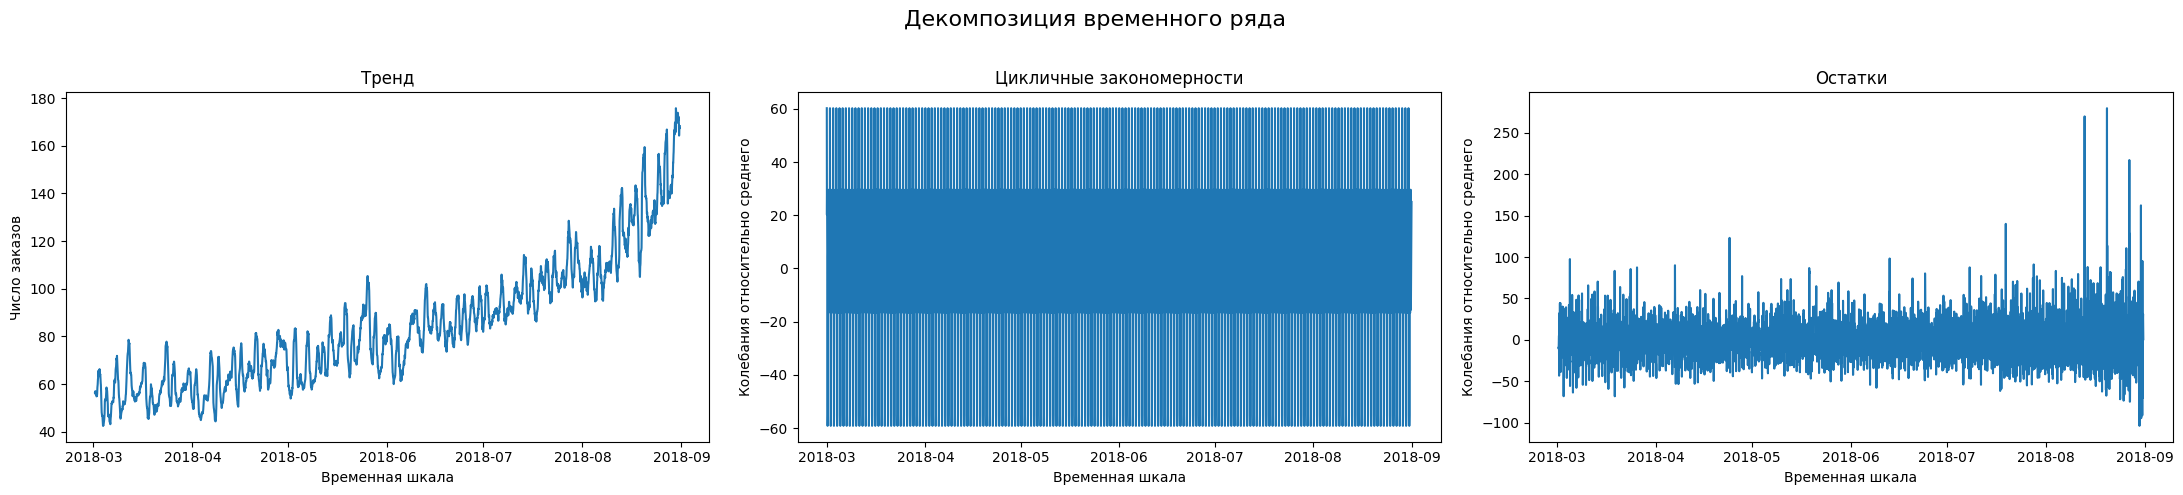

In [14]:
#оценим наличие трендов и закономерностей, для чего декомпозируем данные
decomposed = seasonal_decompose(data)

#сначала посмотрим на данные в целом
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Декомпозиция временного ряда', fontsize=16)

ax1.plot(decomposed.trend)
ax1.set_title('Тренд')
ax1.set_ylabel('Число заказов')
ax1.set_xlabel('Временная шкала')

ax2.plot(decomposed.seasonal)
ax2.set_title('Цикличные закономерности')
ax2.set_ylabel('Колебания относительно среднего')
ax2.set_xlabel('Временная шкала')

ax3.plot(decomposed.resid)
ax3.set_title('Остатки')
ax3.set_ylabel('Колебания относительно среднего')
ax3.set_xlabel('Временная шкала')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- За полгода наблюдается тренд на увеличение числа заказов. Вероятно, это связано с развитием сервиса в целом.
- Цикличных закономерностей за весь период не выявлено. Однако, мы посмотрим отдельно на данные по месяцам, неделям и дням.
- График остатков тоже в целом не примечателен, разве что чуть больше нетипично больших значений в августе.

### Обзор в разрезе месяца

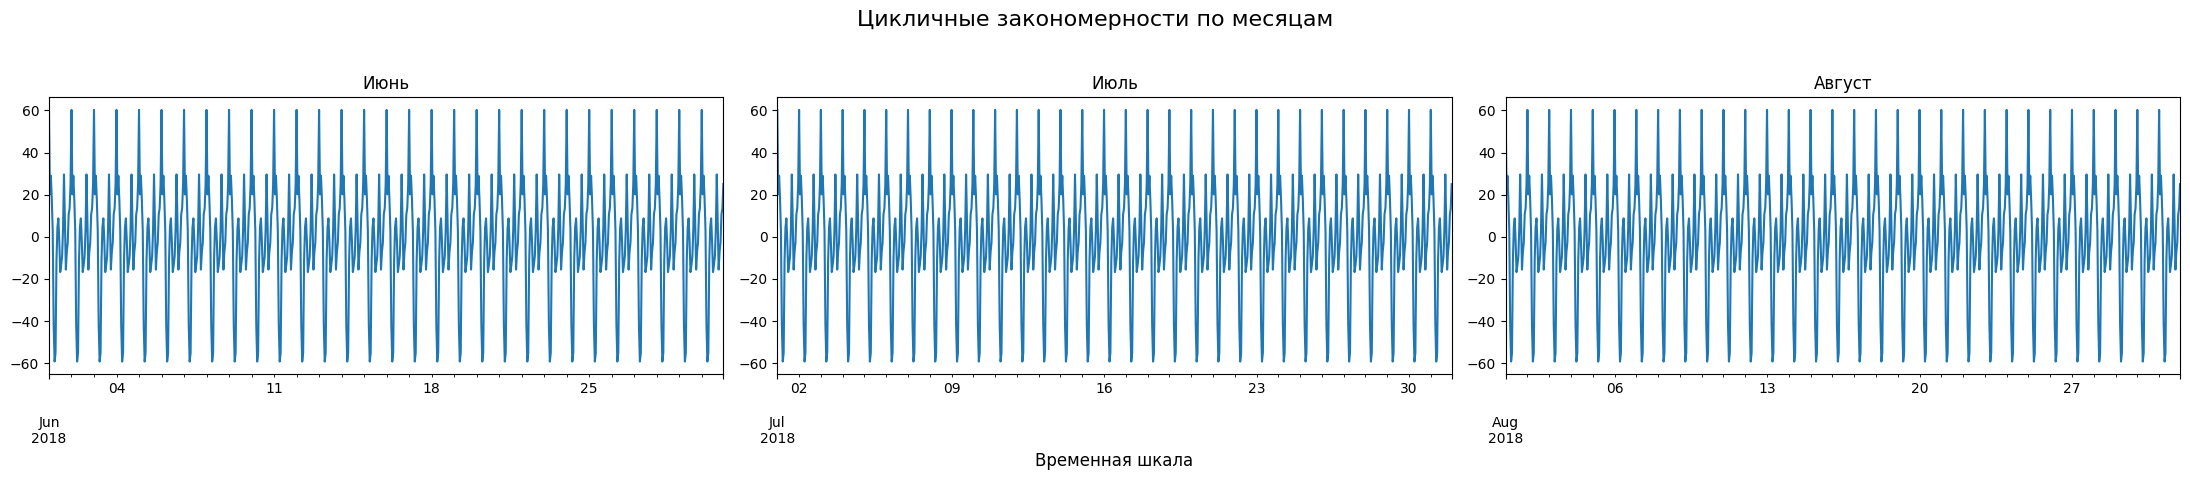

In [15]:
#посмотрим на данные по месяцам
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Цикличные закономерности по месяцам', fontsize=16)

decomposed.seasonal['2018-06-01':'2018-06-30'].plot(ax=axs[0])
axs[0].set_title('Июнь')
axs[0].set_xlabel('')

decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=axs[1])
axs[1].set_title('Июль')
axs[1].set_xlabel('Временная шкала', fontsize=12)

decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=axs[2])
axs[2].set_title('Август')
axs[2].set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- Цикличная закономерность есть, но скорее в разрезе меньшего периода.

### Обзор в разрезе недели

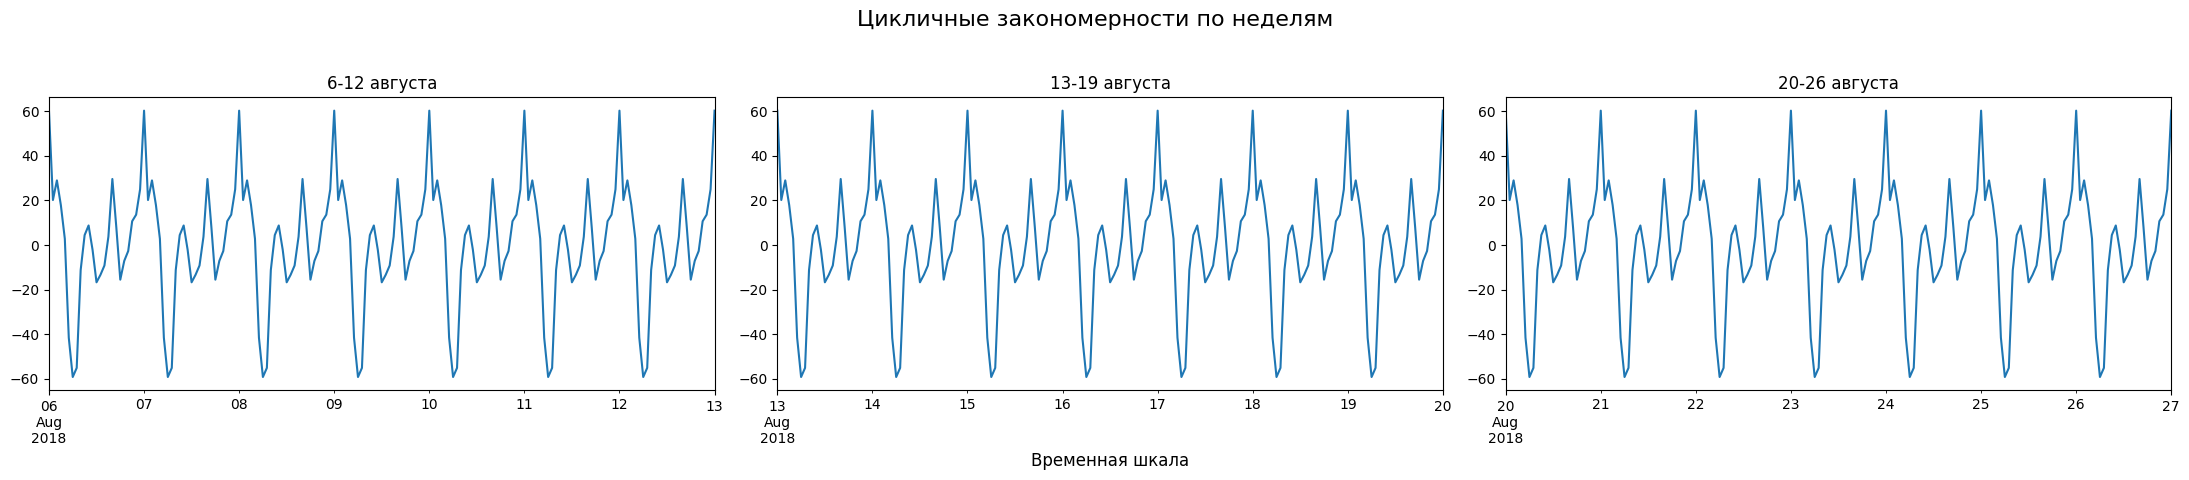

In [16]:
#посмотрим на данные по неделям
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Цикличные закономерности по неделям', fontsize=16)

decomposed.seasonal['2018-08-06 00:00':'2018-08-13 00:00'].plot(ax=axs[0])
axs[0].set_title('6-12 августа')
axs[0].set_xlabel('')

decomposed.seasonal['2018-08-13 00:00':'2018-08-20 00:00'].plot(ax=axs[1])
axs[1].set_title('13-19 августа')
axs[1].set_xlabel('Временная шкала', fontsize=12)

decomposed.seasonal['2018-08-20 00:00':'2018-08-27 00:00'].plot(ax=axs[2])
axs[2].set_title('20-26 августа')
axs[2].set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Цикл есть, но он меньше недели.

### Обзор в разрезе дня

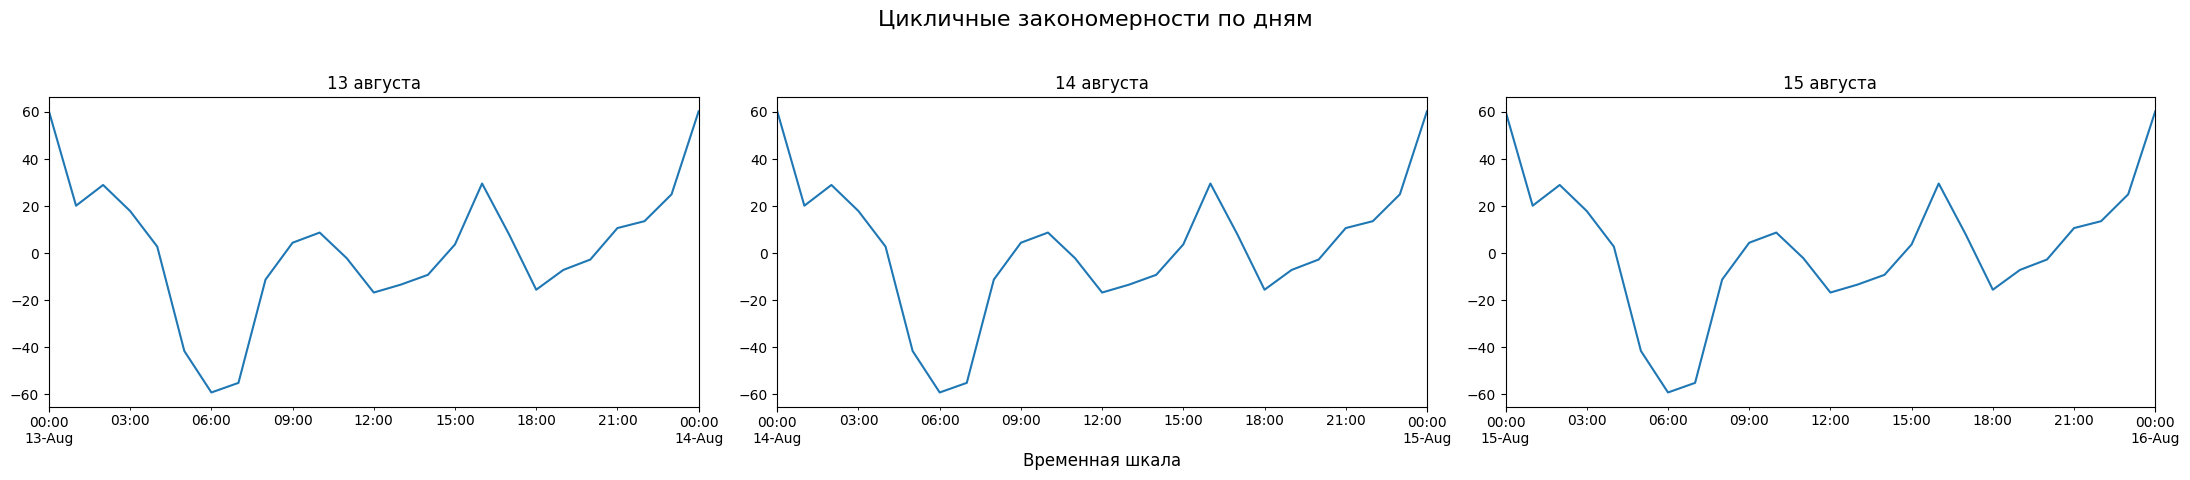

In [17]:
#посмотрим на данные по дням

fig, axs = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Цикличные закономерности по дням', fontsize=16)

decomposed.seasonal['2018-08-13 00:00':'2018-08-14 00:00'].plot(ax=axs[0])
axs[0].set_title('13 августа')
axs[0].set_xlabel('')

decomposed.seasonal['2018-08-14 00:00':'2018-08-15 00:00'].plot(ax=axs[1])
axs[1].set_title('14 августа')
axs[1].set_xlabel('Временная шкала', fontsize=12)

decomposed.seasonal['2018-08-15 00:00':'2018-08-16 00:00'].plot(ax=axs[2])
axs[2].set_title('15 августа')
axs[2].set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- Популярность такси заметно колеблется в течение дня: от низшей точки в 6 утра до пика в полночь с небольшими провалами в полдень и в 6 вечера.

### Выводы из исследовательского анализа

- Общий тренд демонстрирует ускоряющийся рост числа заказов за исследуемый период.
- Популярность такси заметно колеблется в течение дня: от низшей точки в 6 утра до пика в полночь с небольшими провалами в полдень и в 6 вечера. 

## Создание признаков

### Новые признаки в датасете

Добавим следующие признаки на базе имеющихся данных:
- Календарные признаки:
  - месяц
  - день недели
  - час
- Скользящее среднее с шириной окна 3.
- Отстающие значения, на последовательных 5 шагов назад.

Далее - удалим неизбежные пропуски.

In [18]:
#добавим признаков, чтобы моделям было веселее
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data['rolling_mean'] = data['num_orders'].shift().rolling(3).mean()
for lag in range(1, 25):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) 

#и удалим пропуски, чтобы модели не загрустили от пропусков
data.dropna(inplace=True)

#посмотрим на красивое
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   month         4392 non-null   int32  
 2   dayofweek     4392 non-null   int32  
 3   hour          4392 non-null   int32  
 4   rolling_mean  4392 non-null   float64
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17  lag_13        4392 non-null

In [19]:
data.head()

,num_orders,month,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,4,0,79.000000,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,3,4,1,87.000000,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,3,4,2,89.333333,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,3,4,3,95.000000,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,3,4,4,86.333333,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


- Все признаки на месте, тип данных верный, пропусков нет.

### Выводы по созданию признаков

- Было создано 9 новых численных признаков.
- Пропуски устранены.

## Создание моделей прогноза числа заказов

Создадим четыре модели прогноза числа заказов.
- Линейная регрессия
- RandomForestRegressor
- LightGBM
- CatBoost

Критерии оценки моделей:
- Качество предсказания на тестовой выборке: RMSE < 48

In [20]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

#проверим размеренность
print('Размеренность датасета с входными данными:', X.shape[0], X.shape[1])
print('Размеренность датасета с тренеровочными данными:', X_train.shape[0], X_train.shape[1])
print('Размеренность датасета с тестовыми данными:', X_test.shape[0], X_test.shape[1])

Размеренность датасета с входными данными: 4392 28
Размеренность датасета с тренеровочными данными: 3952 28
Размеренность датасета с тестовыми данными: 440 28


### Модель LinearRegression

In [21]:
#создадим и обучим модель линейной регрессии
model_lr = LinearRegression()


#чуть заморочимся с кодированием на входе
numerical_features = ['rolling_mean', 'lag_1', 'lag_2', 
                      'lag_3', 'lag_4', 'lag_5', 
                      'lag_6', 'lag_7', 'lag_8', 
                      'lag_9', 'lag_10', 'lag_11', 
                      'lag_12', 'lag_13', 'lag_14', 
                      'lag_15', 'lag_16', 'lag_17', 
                      'lag_18', 'lag_19', 'lag_20', 
                      'lag_21', 'lag_22', 'lag_23', 
                      'lag_24']
categorical_features = ['month', 'dayofweek', 'hour']

#категориальные признаки
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_ohe = ohe_encoder.fit_transform(X_train[categorical_features])
X_test_cat_ohe = ohe_encoder.transform(X_test[categorical_features])
ohe_feature_names = ohe_encoder.get_feature_names_out(categorical_features)

X_train_cat_ohe_pd = pd.DataFrame(X_train_cat_ohe, columns=ohe_feature_names, index=X_train.index)
X_test_cat_ohe_pd = pd.DataFrame(X_test_cat_ohe, columns=ohe_feature_names, index=X_test.index)

#количественные признаки
scaler = MinMaxScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_num_scaled = scaler.transform(X_test[numerical_features])

X_train_num_scaled_pd = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=X_train.index)
X_test_num_scaled_pd = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=X_test.index)

#финальный набор для модели
X_train_final = pd.concat([X_train_num_scaled_pd, X_train_cat_ohe_pd], axis=1)
X_test_final = pd.concat([X_test_num_scaled_pd, X_test_cat_ohe_pd], axis=1)



model_lr.fit(X_train_final, y_train)
y_pred_lr = model_lr.predict(X_train_final)

#оценим работу линейной модели
rmse_lr = root_mean_squared_error(y_train, y_pred_lr)
print("RMSE модели LinearRegression на тренировочной выборке: %.2f" % rmse_lr)

RMSE модели LinearRegression на тренировочной выборке: 22.76


### Модель RandomForestRegressor

In [22]:
#создадим и обучичм модель CatBoostRegressor
model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

parameters = {
    'n_estimators':range(50,100,10), 
    'max_depth':range(1,11,2)
}

tscv = TimeSeriesSplit(n_splits=2)
gsearch_forest = GridSearchCV(
    estimator=model_forest, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    param_grid=parameters)
gsearch_forest.fit(X_train, y_train)


rmse_forest = round((gsearch_forest.best_score_ * -1), 4)

print("Лучшие параметры модели RandomForestRegressor:", gsearch_forest.best_params_)
print("RMSE лучшей модели RandomForestRegressor:", rmse_forest)


Лучшие параметры модели RandomForestRegressor: {'max_depth': 9, 'n_estimators': 50}
RMSE лучшей модели RandomForestRegressor: 28.065


### Модель CatBoostRegressor

In [23]:
#создадим и обучичм модель CatBoostRegressor
model_catboost = CatBoostRegressor(verbose=False)

param_grid = {
    'learning_rate': [0.03, 0.05, 0.1],
    'depth': [6, 8],
    'iterations': [1000],
    'grow_policy': ['SymmetricTree'],
    'random_strength': [0, 5]
}

tscv = TimeSeriesSplit(n_splits=5)

rsearch_catboost = RandomizedSearchCV(
    estimator=model_catboost,
    param_distributions=param_grid,
    n_iter=6,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rsearch_catboost.fit(X_train, y_train)

rmse_catboost = round((rsearch_catboost.best_score_ * -1), 4)

print("Лучшие параметры:", rsearch_catboost.best_params_)
print("RMSE лучшей модели CatBoostRegressor:", rmse_catboost)



Лучшие параметры: {'random_strength': 0, 'learning_rate': 0.05, 'iterations': 1000, 'grow_policy': 'SymmetricTree', 'depth': 6}
RMSE лучшей модели CatBoostRegressor: 24.2177


### Модель LGBMRegressor

In [40]:
#создадим и обучичм модель LGBMRegressor
model_lgb = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)

param_grid = {
    'num_leaves': [25, 31, 50],
    'learning_rate': [0.03, 0.05, 0.1],
    'n_estimators': [500, 1000]
}

rsearch_lgbr = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

# Обучение
rsearch_lgbr.fit(X_train, y_train)

# Результаты
rmse_lgbr = round((rsearch_lgbr.best_score_ * -1), 4)

print("Лучшие параметры:", rsearch_lgbr.best_params_)
print("RMSE лучшей модели LGBMRegressor:", rmse_lgbr)


Лучшие параметры: {'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.03}
RMSE лучшей модели LGBMRegressor: 24.9245


### Анализ моделей

In [41]:
#соберем данные в табличку
models_comparison = pd.DataFrame({'Модель': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
                        'RMSE': [rmse_lr, rmse_forest, rmse_catboost, rmse_lgbr]})

models_comparison


,Модель,RMSE
0,LinearRegression,22.757875
1,RandomForestRegressor,28.065000
2,CatBoostRegressor,24.217700
3,LGBMRegressor,24.924500


- Лучшая модель на данный момент - LinearRegressor. Ее начение RMSE на тренеровочных данных 22.757875.
- Второй лучший результат - у моделей CatBoostRegressor и LGBMRegressor с разницей всего 0.7.
- Лучшая модель отличается от ближайших по результату всего 1.46 и 2.16.
- В условиях небольшой разницы между моделями, напоминающих скорее погрешность, чем реальные отличия, мы проверим RMSE на тестовой выборке всех моделей. 

### Проверка на тестовой выборке

In [42]:
y_pred_lr_test = model_lr.predict(X_test_final)

#оценим работу модели LinearRegression на тестовой выборке
rmse_lr_test = root_mean_squared_error(y_test, y_pred_lr_test)
print("RMSE LinearRegression на тестовой выборке: %.2f" % rmse_lr_test)

RMSE LinearRegression на тестовой выборке: 43.13


In [43]:
y_pred_forest_test = gsearch_forest.predict(X_test)

#оценим работу модели RandomForestRegressor на тестовой выборке
rmse_forest_test = root_mean_squared_error(y_test, y_pred_forest_test)
print("RMSE RandomForestRegressor на тестовой выборке: %.2f" % rmse_forest_test)

RMSE RandomForestRegressor на тестовой выборке: 43.39


In [44]:
y_pred_catboost_test = rsearch_catboost.predict(X_test)

#оценим работу модели CatBoostRegressor на тестовой выборке
rmse_catboost_test = root_mean_squared_error(y_test, y_pred_catboost_test)
print("RMSE CatBoostRegressor на тестовой выборке: %.2f" % rmse_catboost_test)

RMSE CatBoostRegressor на тестовой выборке: 42.33


In [45]:
y_pred_lgbr_test = rsearch_lgbr.predict(X_test)

#оценим работу модели LGBMRegressor на тестовой выборке
rmse_lgbr_test = root_mean_squared_error(y_test, y_pred_lgbr_test)
print("RMSE LGBMRegressor на тестовой выборке: %.2f" % rmse_lgbr_test)

RMSE LGBMRegressor на тестовой выборке: 39.78


In [46]:
#соберем данные в табличку
models_final_comparison = pd.DataFrame({'Модель': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
                        'RMSE': [rmse_lr_test, rmse_forest_test, rmse_catboost_test, rmse_lgbr_test]})

models_final_comparison

,Модель,RMSE
0,LinearRegression,43.132742
1,RandomForestRegressor,43.390818
2,CatBoostRegressor,42.330408
3,LGBMRegressor,39.783029


- Модель LGBMRegressor показала себя заметно лучше других на тестовых данных. Разница со второй лучшей - 2.55.
- RMSE всех моделей на тестовой выборке соответствуют заявленному критерию для RMSE - меньше 48.

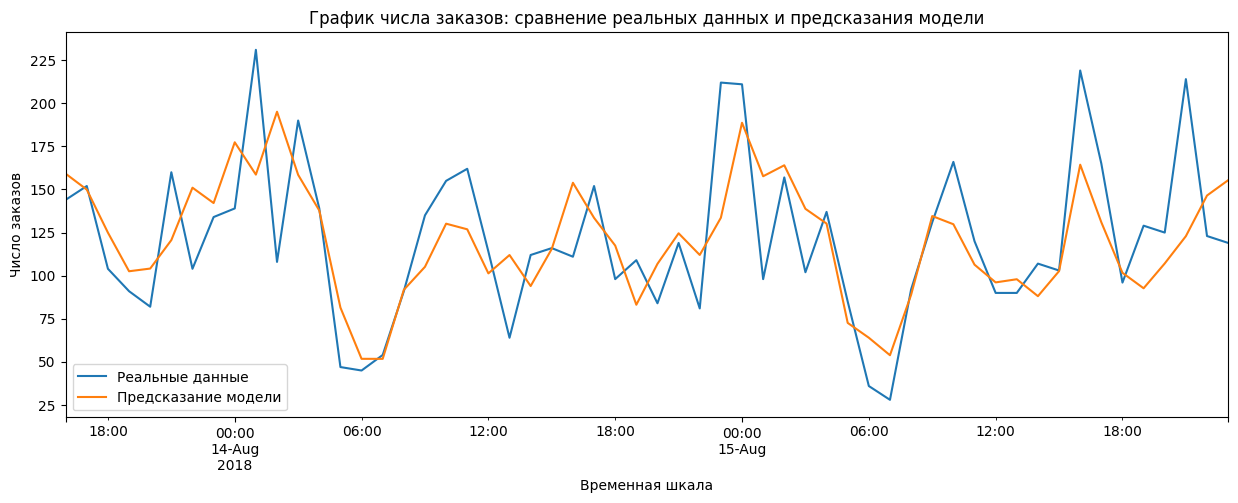

In [49]:
#сравним графики предсказания и реальные данные, чтобы понять, делает ли модель какие-то специфические ошибки
y_pred_lgbr_test = pd.DataFrame(y_pred_lgbr_test, index = y_test.index)

fig, ax = plt.subplots(figsize=(15, 5))
y_test['2018-08-13':'2018-08-15'].plot(ax=plt.gca(), label='Реальные данные')
y_pred_lgbr_test['2018-08-13':'2018-08-15'].plot(ax=plt.gca(), label='Предсказание модели')

plt.title('График числа заказов: сравнение реальных данных и предсказания модели')
plt.legend(['Реальные данные', 'Предсказание модели'])
plt.xlabel('Временная шкала')
plt.ylabel('Число заказов')
plt.show()


- Модель в целом верно улавливает тенденции, однако склонна занижать пиковые верхние значения.

### Выводы по созданию моделей

- Рекомендуемая для внедрения модель - LGBMRegressor. 
- Параметры лучшей модели: 'num_leaves' - 31, 'n_estimators' - 500,'learning_rate' - 0.03.
- RMSE лучшей модели при кросс-валидации на тренеровочных данных 24.92, на тестовых - 39.78.
- RMSE всех моделей на тестовой выборке соответствуют заявленному критерию для RMSE - меньше 48.
- Для улучшения качества и стабильности предсказания рекомендуется увеличение объема данных, как в части протяженности периода, так и в части дополнительных признаков, например, погодных условий в моменте.

## Общие выводы

**Ход проекта**
1. **Обзор и предобработка данных**
   - Значительных минусов и аномалий в данных не было выявлено.
   - Был скорректирован тип данных в столбце datetime, он же был установлен в качестве индекса.
   - Данные были упорядочены хронологически.
   - Данные были ресемплированы по часу.
2. **Исследовательский анализ данных**
   - Общий тренд демонстрирует ускоряющийся рост числа заказов за исследуемый период.
   - Популярность такси заметно колеблется в течение дня: от низшей точки в 6 утра до пика в полночь с небольшими провалами в полдень и в 6 вечера. 
3. **Создание дополнительных признаков на основе имеющихся данных**
   - Были созданы дополнительные 9 признаков на основе имеющихся данных:
     - Месяц
     - День недели 
     - Час
     - Скользящее среднее с окном в 3, чтобы понимать общий тренд в моменте.
     - Отстающие значения с последовательным шагом 5, чтобы понимать предыдущие состояния.
4. **Обучение и выбор моделей**
   - Были обучены 4 модели: LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor.
   - Рекомендуемая для внедрения модель - LGBMRegressor.
   - Параметры лучшей модели: 'num_leaves' - 31, 'n_estimators' - 500, 'learning_rate' - 0.03.
   - RMSE лучшей модели при кросс-валидации на тренеровочных данных 24.92, на тестовых - 39.78.
   - RMSE всех моделей на тестовой выборке соответствуют заявленному критерию для RMSE - меньше 48.


_______

**Дополнительные рекомендации**

**Рекомендуется сбор дополнительных данных для улучшения качества и стабильности модели**
- Рекомендуется обучение на данных с бОльшим периодом, т.к. имеется тенденция к росту популярности сервиса в целом, а также возможного выявления закономерностей в течение года. Например, текущий период не поздволяет сделать выводы о повышении спроса на такси летом - является ли это исключительно продолжением тренда на рост популярности сервиса или следствием сезона отпусков.
- Рекомендуется сбор дополнительных данных, которые могут влиять на число заказов. Например, погодные условия, акционные периоды сервиса и т.д.
